In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, ConcatDataset
from torch.utils.data import sampler

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models as models

from PIL import Image
import warnings

# constants
repo_path = Path('/Users/etriesch/dev/tree-finder/')
model_path = repo_path / 'models'

# disable warnings
Image.MAX_IMAGE_PIXELS = None # image processing 

In [2]:
# setup computing
USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda


In [3]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# define paths
repo_path = Path('git/tree-finder/')
full_repo_path = Path('/content/drive/My Drive ') / repo_path
model_path = full_repo_path / 'models'

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(repo_path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# setup cell
from notebooks.plot_fns import show_image_batch, set_plt_settings, plot_accs
from notebooks.train_fns import flatten, Flatten, train_model
from notebooks.models import ResnetBinClassifier
from notebooks.data_processing import define_transforms, make_dataloaders, IMAGE_DIM, MEAN, STD

# And change jupyter settings to auto-reload these functions before each instance running them
%load_ext autoreload
%autoreload 2

In [5]:
set_plt_settings()

# Make dataset and loaders
This includes augmenting my dataset

In [11]:
# define transformations
transforms = define_transforms(scale_up=1024, crop=1024, scale_out=IMAGE_DIM, mean=MEAN, std=STD, mirror=True, randomcrop=True)

# create dataset by concatenating all transformations
binds = []
for t in transforms:
    df = dset.ImageFolder(root= full_repo_path / 'data/images_bin', transform=transforms[t])
    binds.append(df)

binds = ConcatDataset(binds)
class_names = binds.datasets[0].classes
print('class names:', class_names)

# make dataloaders
dataloaders, ds_sizes = make_dataloaders(dataset=binds, test_split=0.10, val_split=0.25, sampleN=8, batch_size=32, seed=None)

class names: ['nottree', 'tree']
dataloader sizes: {'all': 10408, 'train': 7025, 'validate': 2342, 'test': 1041, 'sampler': 8}


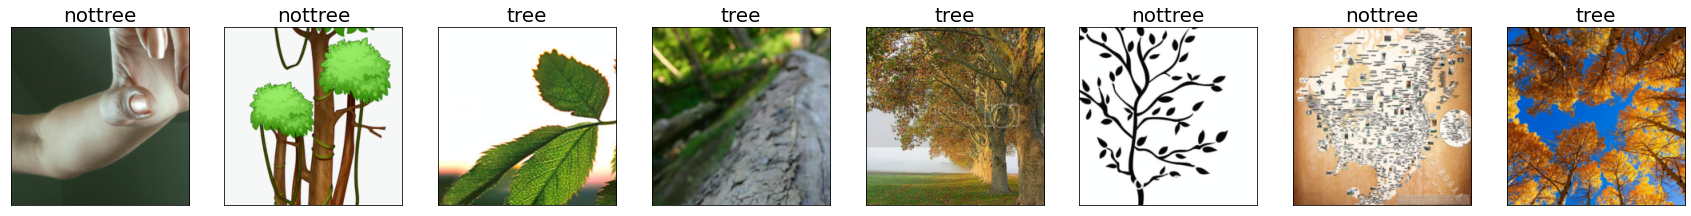

In [12]:
# visualize images
samp_input, samp_class = next(iter(dataloaders['sampler']))

# print(type(imgs), type(labels))
show_image_batch(samp_input, mean=MEAN, std=STD, 
                 title=[class_names[x] for x in samp_class])

# Retrain a pretrained model for binary classification of trees

## Overfit on small data

In [13]:
small_data_train_size = 500
small_data_validate_size = 100
small_batch_size = 25
small_loaders = {}
small_loaders['train'] = DataLoader(binds, batch_size=small_batch_size,
                           sampler=sampler.SubsetRandomSampler(np.random.randint(0, len(binds), small_data_train_size)))
small_loaders['validate'] = DataLoader(binds, batch_size=small_batch_size,
                           sampler=sampler.SubsetRandomSampler(np.random.randint(0, len(binds), small_data_validate_size)))
small_ds_sizes = {'train':small_data_train_size, 'validate':small_data_validate_size}

In [16]:
model = ResnetBinClassifier(resnet50=False)
model = model.to(device)
print(model.get_grad_state())
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)
scheduler_lr = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) #lr decay

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

loading pretrained resnet18...
{'unfrozen': ['fc'], 'frozen': ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']}


  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
validate epoch: [2/2] Loss: 0.2985 ACC@1: 97.00%: 100%|██████████| 4/4 [00:49<00:00, 12.39s/it]


Returning best model, with validation accuracy 0.97


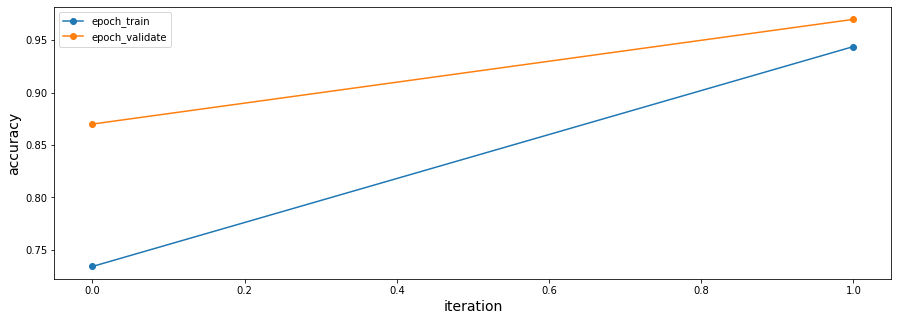

In [18]:
acc_history = train_model(model, criterion, optimizer, scheduler_lr,
                          small_loaders, small_ds_sizes, device, 2)
plot_accs({key: acc_history[key] for key in ['epoch_train', 'epoch_validate']})

## Train using entire dataset

In [19]:
model = ResnetBinClassifier(resnet50=True)
model = model.to(device)
print(model.get_grad_state())
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)
scheduler_lr = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1) # lr decay

loading pretrained resnet50...
{'unfrozen': ['fc'], 'frozen': ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']}


In [20]:
acc_history = train_model(model, criterion, optimizer, scheduler_lr,
                                   dataloaders, ds_sizes, device, 6)
plot_accs({key: acc_history[key] for key in ['epoch_train', 'epoch_validate']})
torch.save(model.state_dict(), model_path / 'ResnetBinClassifier.pt')

train epoch: [1/6] Loss: 0.6748 ACC@1: 64.73%:   3%|▎         | 7/220 [01:52<56:44, 15.98s/it]/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
train epoch: [1/6] Loss: 0.3561 ACC@1: 92.39%:  35%|███▍      | 76/220 [22:27<42:32, 17.72s/it]


UnidentifiedImageError: ignored

In [ ]:
%cd '/content/drive/My Drive /git/tree-finder'
!git config --global user.email "erich.j.trieschman@gmail.com"
!git config --global user.name "Erich Trieschman"

!git add .
!git commit -m 'rerun pretrained model'
!git push

/content/drive/My Drive /git/tree-finder
[main bfc68c9] rerun pretrained model
 9 files changed, 32 insertions(+), 842 deletions(-)
 create mode 100644 notebooks/__pycache__/data_processing.cpython-37.pyc
 create mode 100644 notebooks/data_processing.py
 rewrite notebooks/preprocess_images.ipynb (73%)
 rewrite notebooks/train_binary_tree_classifier.ipynb (86%)
Counting objects: 14, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (14/14), done.
Writing objects: 100% (14/14), 86.86 MiB | 7.03 MiB/s, done.
Total 14 (delta 4), reused 0 (delta 0)
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
remote: warning: See http://git.io/iEPt8g for more information.
remote: warning: File models/ResnetBinClassifier.pt is 90.98 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB
remote: warning: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com.
To https://github.com/etrieschman/tree